In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = True
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

In [3]:
%cd ~/avid

/home/nmiklaucic/avid


In [ ]:
from jarvis.db.figshare import data

data3d = data('dft_3d')

In [ ]:
df = pd.DataFrame(data3d)
df.head()

In [ ]:
from jarvis.core.atoms import Atoms
from pymatgen.io.jarvis import JarvisAtomsAdaptor

df['atoms'] = [JarvisAtomsAdaptor.get_structure(Atoms.from_dict(a)) for a in df['atoms']]
df.head()

In [ ]:
for col in df.columns:
    if 'na' in df[col].values:
        try:
            df[col] = pd.to_numeric(df[col].replace('na', np.nan))
        except (TypeError, ValueError):
            print(col)

df.select_dtypes(include='number')

In [ ]:
from pymatgen.core import Composition
df['spg_number'] = df['spg_number'].astype(int)
df['formula'] = [Composition(f) for f in df['formula']]
df['num_spec'] = [len(f.elements) for f in df['formula']]
print(df.shape)
df.head()

In [ ]:
col_nans = df.select_dtypes('number').isna().mean(axis=0).sort_values()
col_nans

In [ ]:
df['magmom'] = np.where(df.eval('magmom_outcar < 0'), df['magmom_oszicar'], df['magmom_outcar'])
print(df['magmom'].isna().mean())
df['magmom'].quantile(np.linspace(0, 1, 9))

In [ ]:
clean = df.dropna(axis=1, thresh=0.94 * len(df.index))
clean = clean.drop(columns=['magmom_outcar', 'spg_symbol', 'jid', 'func', 'effective_masses_300K', 'typ', 'spg', 'raw_files', 'reference', 'search', 'elastic_tensor', 'kpoint_length_unit', 'icsd', 'xml_data_link', 'modes', 'encut', 'efg'])
clean

In [ ]:
clean = clean.query('crys == "cubic"').drop(columns=['crys'])
clean.shape

In [ ]:
pd.value_counts(clean['dimensionality'])

In [ ]:
pd.value_counts(clean['nat'].clip(None, 20)).sort_index()[:20]

In [ ]:
clean = clean.query('nat <= 14')

In [ ]:
from collections import Counter

els = Counter()

for form in clean['formula']:
    for el in form.elements:
        els[el] += 1

els = pd.Series(els)
filtered = els.sort_values()[-72:]
filtered

In [ ]:
clean = clean[[all(e in filtered.index for e in f.elements) for f in clean['formula']]]
clean

In [ ]:
pd.value_counts(clean['num_spec']).sort_index()

In [ ]:
clean = clean.query('num_spec <= 4')
clean

In [ ]:
clean['magmom'] = clean['magmom'].fillna(0)
clean = clean.rename(columns={'optb88vdw_bandgap': 'bandgap', 'nat': 'num_atoms', 'spg_number': 'space_group', 'formation_energy_peratom': 'e_form', 'optb88vdw_total_energy': 'e_total'})
clean

In [ ]:
clean.sort_values('e_form')

I'm mostly removing the last two N columns so the dataset size evenly divides 32, but they are outliers.

In [ ]:
clean = clean.query('e_form < 5')
clean

In [ ]:
clean.to_pickle('precomputed/jarvis_dft3d_cleaned/dataframe.pkl')

In [4]:
clean = pd.read_pickle('precomputed/jarvis_dft3d_cleaned/dataframe.pkl')

In [93]:
pd.value_counts(clean['space_group'])

/tmp/ipykernel_3625538/2441825717.py:1: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.



space_group
225    6498
221    3922
216    3269
227     680
215     204
229     131
223     105
198     104
205     101
220      69
200      37
224      25
217      23
199      17
206       5
204       4
212       3
213       2
214       1
Name: count, dtype: int64

No idea what radial basis makes sense. For now, I use a Gaussian scaled so 1 is the peak, with standard deviation equal to half of the atomic radius.

In [5]:
elements = set()
for struct in clean['atoms']:
    elements.update(set(struct.elements))

print(len(elements))
print(elements)

sorted_elements = sorted(elements, key=lambda e: e.number)
elem_vals = [elem.symbol for elem in sorted_elements]
print(' '.join(elem_vals))

72
{Element H, Element Li, Element Be, Element B, Element C, Element N, Element O, Element F, Element Na, Element Mg, Element Al, Element Si, Element P, Element S, Element Cl, Element K, Element Ca, Element Sc, Element Ti, Element V, Element Cr, Element Mn, Element Fe, Element Co, Element Ni, Element Cu, Element Zn, Element Ga, Element Ge, Element As, Element Se, Element Br, Element Rb, Element Sr, Element Y, Element Zr, Element Nb, Element Mo, Element Tc, Element Ru, Element Rh, Element Pd, Element Ag, Element Cd, Element In, Element Sn, Element Sb, Element Te, Element Ba, Element La, Element Ce, Element Pr, Element Nd, Element Pm, Element Sm, Element Dy, Element Ho, Element Er, Element Tm, Element Yb, Element Lu, Element Hf, Element Ta, Element W, Element Os, Element Ir, Element Pt, Element Au, Element Hg, Element Tl, Element Pb, Element Bi}
H Li Be B C N O F Na Mg Al Si P S Cl K Ca Sc Ti V Cr Mn Fe Co Ni Cu Zn Ga Ge As Se Br Rb Sr Y Zr Nb Mo Tc Ru Rh Pd Ag Cd In Sn Sb Te Ba La Ce Pr

In [6]:
from jaxtyping import Array, Float, PRNGKeyArray, Float32, Int
import functools as ft
from einops import rearrange, reduce
import flax
import flax.linen as nn
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

dist = tfd.GeneralizedNormal(0.5, 2, 2)

N_GRID = 24
num_cells=4
grid_vals = jnp.linspace(0, 1, N_GRID + 1)[:-1]
xx, yy, zz = jnp.meshgrid(grid_vals, grid_vals, grid_vals)
xyz = rearrange(jnp.array([xx, yy, zz]), 'd n1 n2 n3 -> (n1 n2 n3) d')
xx, yy, zz = jnp.meshgrid(*[jnp.arange(-num_cells, num_cells + 1, dtype=jnp.float32)
                            for _ in range(3)])
shifts = rearrange(jnp.array([xx, yy, zz]), 'd n1 n2 n3 -> (n1 n2 n3) d')
dist.prob(xyz[None, :, :] + shifts[:, None, :]).prod(axis=2).sum(axis=0).mean()

Array(0.9956138, dtype=float32)

In [7]:
from pymatgen.core import Structure
N_GRID = 24
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.108.058301
power = 2.4
eff_scale = jnp.array(0.7)
num_cells = 4


distr = tfd.GeneralizedNormal(0, 1, power)
grid_vals = jnp.linspace(0, 1, N_GRID + 1)[:-1]
xx, yy, zz = jnp.meshgrid(grid_vals, grid_vals, grid_vals)
xyz = rearrange(jnp.array([xx, yy, zz]), 'd n1 n2 n3 -> (n1 n2 n3) d')

@ft.partial(jax.vmap, in_axes=(0, None, None, None))
@ft.partial(jax.jit, static_argnames=['distr', 'num_cells'])
def atom_density(xyz: Float[Array, '3'], atom_xyz: Float[Array, '3'], atom_rad: Float[Array, ''],num_cells: int = 4, distr: tfd.Distribution = distr) -> Float[Array, '']:
    """Atom density.
    xyz: Point at which to calculate density. Fractional coordinates.
    atom_xyz: Atomic center. Cartesian coordinates.
    num_cells: Controls how many cells are used to estimate the sum over all unit cells. Larger values provide slightly higher accuracy but take longer."""
    xx, yy, zz = jnp.meshgrid(*[jnp.arange(-num_cells, num_cells + 1, dtype=jnp.float32)
                                for _ in range(3)])
    shifts = rearrange(jnp.array([xx, yy, zz]), 'd n1 n2 n3 -> (n1 n2 n3) d')
    zscores = (xyz + shifts - atom_xyz) / atom_rad
    return jnp.sum(distr.prob(zscores).prod(axis=1) / distr.prob(0) ** 3)


def parse_grid(struct: Structure) -> (Float[Array, 'n3'], Int[Array, 'n3']):
    scale = struct.lattice.a
    total_dens = 0
    dens = jnp.zeros((N_GRID ** 3, len(elem_vals)))
    for site in struct.sites:
        specie = site.specie
        elem_i = elem_vals.index(specie.symbol)
        atom_dens = atom_density(xyz, site.frac_coords, specie.average_ionic_radius * eff_scale / scale, num_cells)
        dens = dens.at[:, elem_i].set(dens[:, elem_i] + atom_dens)

    total_dens = dens.sum(axis=1)
    species = dens.argmax(axis=1)
    return (dens, total_dens, species)

struct = clean['atoms'].iloc[10]
dens, total_dens, species = parse_grid(struct)

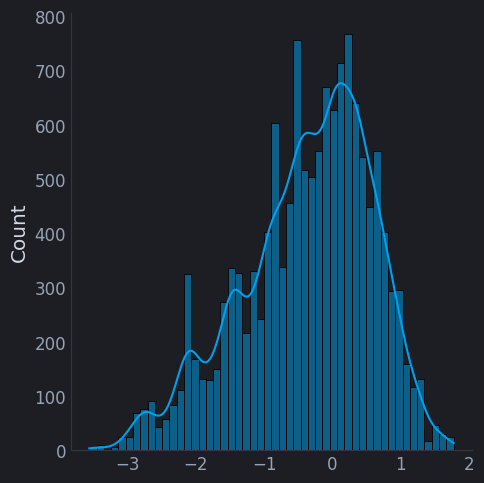

In [29]:
x = total_dens
sns.displot(jax.scipy.special.logit(x.astype(jnp.bfloat16)).astype(jnp.float32) / 4 + 1, kde=True)
# sns.displot(x)

In [ ]:
n_skip = 2
skip_mask = jnp.all(jnp.round(xyz * N_GRID) % n_skip == 0, axis=1)
bg_mask = total_dens > 0.1
mask = skip_mask & bg_mask
px.scatter_3d(
    x=xyz[mask, 0],
    y=xyz[mask, 1],
    z=xyz[mask, 2],
    color=total_dens[mask],
    # color=np.array(species[mask]).astype('str'),
    color_continuous_scale=rp.list_sequential,
    range_x=[0, 1], range_y=[0, 1], range_z=[0, 1],
    opacity=1,
)

In [ ]:
px.scatter_3d(x=struct.frac_coords[:, 0], y=struct.frac_coords[:, 1], z=struct.frac_coords[:, 2], size=[site.specie.average_ionic_radius / struct.lattice.a for site in struct.sites], size_max=200,
              range_x=[0, 1], range_y=[0, 1], range_z=[0, 1], color=[spec.symbol for spec in struct.species])

In [88]:
from tqdm import tqdm
from flax.serialization import msgpack_serialize, msgpack_restore
import gc

make_data = lambda: {
    'density': [],
    'species': [],
    'mask': [],
    'space_group': [],
    'e_form': [],
    'bandgap': [],
    'e_total': [],
    'e_hull': [],
    'magmom': [],
    'cell_density': [],
    'index': []
}

data = make_data()

BATCH_SIZE = 32

clean = clean.sort_index()

rng = np.random.Generator(np.random.PCG64(29205))
clean = clean.loc[rng.permutation(clean.index)]

with jax.default_device(jax.devices('cuda')[1]):
    for i, idx in tqdm(list(enumerate(clean.index))):
        row = clean.loc[idx]
        struct = row['atoms']
        dens, _sum_dens, _spec = parse_grid(struct)
        mask, species = jax.lax.top_k(dens.max(axis=0), max(clean['num_spec']))
        mask = mask > 0
        data['density'].append(dens[:, species].reshape(N_GRID, N_GRID, N_GRID, -1))
        data['species'].append(species)
        data['mask'].append(mask)
        data['cell_density'].append(row['density'])
        data['e_hull'].append(row['ehull'])
        data['index'].append(idx)
        for key in data.keys():
            if key not in ['density'] and key in row.index:
                data[key].append(row[key])

        if (i + 1) % BATCH_SIZE == 0:
            for col in ('species', 'space_group'):
                data[col] = jnp.array(data[col], dtype=jnp.uint8)
            for col in ('index',):
                data[col] = jnp.array(data[col], dtype=jnp.uint32)
            for col in ('mask',):
                data[col] = jnp.array(data[col], dtype=jnp.bool)
            for col in ('density', 'e_form', 'bandgap', 'e_total', 'e_hull', 'magmom', 'cell_density'):
                data[col] = jnp.array(data[col], dtype=jnp.float32)

            batch_ind = (i + 1) // BATCH_SIZE - 1

            with open(f'precomputed/jarvis_dft3d_cleaned/batch{batch_ind}.mpk', 'wb') as out:
                out.write(msgpack_serialize(data))

            del data
            data = make_data()


100%|██████████| 15200/15200 [03:01<00:00, 83.91it/s]


In [1]:
with open('precomputed/jarvis_dft3d_cleaned/batch1.mpk', 'rb') as bat:
    data2 = msgpack_restore(bat.read())

FileNotFoundError: [Errno 2] No such file or directory: 'precomputed/jarvis_dft3d_cleaned/batch1.mpk'

In [ ]:
clean.head()

In [89]:
import json
metadata = {
    'elements': elem_vals,
    'power': power,
    'eff_scale': eff_scale.item(),
    'n_grid': N_GRID,
    'batch_size': BATCH_SIZE,
    'num_cells': num_cells,
    'data_size': len(clean.index)
}

with open('precomputed/jarvis_dft3d_cleaned/metadata.json', 'w') as out:
    json.dump(metadata, out)